In [1]:
%matplotlib inline

#Load required modules
import sys, os, argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import math
from scipy.stats import chisquare
import graphviz as gv
# sns.set_style('whitegrid')

### Set up seaborn appearence
mpl.rc('text', usetex = True)
sns.set_context("notebook", font_scale=1.75)
plt.rc("axes.spines", top=True, right=True)

In [2]:
# Load oncolib module
sys.path.append("/Users/melkebir/Projects/OncoSim/build/")
# sys.path.append("/Users/melkebir/Projects/OncoSim/build2/Debug")
import oncolib

# 1. Generate simulations

In [3]:
mutRateList = [0.1, 0.2, 0.4]
mutClusterCountDict = {3:0.1, 5:0.1, 7:0.2, 9:0.2, 11:0.4, 13:0.4}
mutClusterCountDictNew = {15:0.4, 17:0.6, 19:0.6, 21:0.8}
sampleCountList = [1, 2, 5, 10]
# sampleCountList = [2]

## 1.1 Simulate tumors

In [4]:
if not os.path.exists("simulate_output"):
    os.mkdir("simulate_output")

for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    out_dir = "simulate_output/n%d" % (n)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

        oncolib.simulate(out_dir, {'nrSamplesPerAnatomicalSite' : 0, 'nrTrials' : 10, 
                                   'desiredNrMutationClusters' : n,
                                   'maxNrAnatomicalSites' : 1, 'nrSamplesPrimary' : 1,
                                   'mutationRate' : M})

## 1.2 Generate samples from each simulated tree

In [ ]:
if not os.path.exists("mix_output"):
    os.mkdir("mix_output")
    
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    in_dir = "simulate_output/n%d" % (n)
    for filename in glob.glob(in_dir + "/*.tree"):
        seed = int(filename.rstrip(".tree").split("/")[-1].split("_")[-1].lstrip('seed'))
        for k in sampleCountList:
            out_filename = "mix_output/n%d_S%d_k%d.tree" % (n, seed, k)
            oncolib.mix(filename, out_filename, k, True)
            out_filename_freqs = "mix_output/n%d_S%d_k%d.tsv" % (n, seed, k)
            oncolib.tree2freqs(out_filename, out_filename_freqs)
            out_filename_precluster = "mix_output/n%d_S%d_k%d_clustered.tsv" % (n, seed, k)
            clustering_filename = "simulate_output/n%d/clustering_observed_seed%d.txt" % (n, seed)
            oncolib.precluster(out_filename_freqs, clustering_filename, out_filename_precluster)

In [8]:
for n in mutClusterCountDictNew:
    M = mutClusterCountDictNew[n]
    in_dir = "simulate_output/n%d" % (n)
    for filename in glob.glob(in_dir + "/*.tree"):
        seed = int(filename.rstrip(".tree").split("/")[-1].split("_")[-1].lstrip('seed'))
        for k in [5, 10]:
            out_filename = "mix_output/n%d_S%d_k%d.tree" % (n, seed, k)
            oncolib.mix(filename, out_filename, k, True)
            out_filename_freqs = "mix_output/n%d_S%d_k%d.tsv" % (n, seed, k)
            oncolib.tree2freqs(out_filename, out_filename_freqs)
            out_filename_precluster = "mix_output/n%d_S%d_k%d_clustered.tsv" % (n, seed, k)
            clustering_filename = "simulate_output/n%d/clustering_observed_seed%d.txt" % (n, seed)
            oncolib.precluster(out_filename_freqs, clustering_filename, out_filename_precluster)

# 2. Solve simulated instances

## 2.1 Enumerate mutation trees

First dry (only counts) then non-dry (actual trees).

In [ ]:
if not os.path.exists("enumerate_output"):
    os.mkdir("enumerate_output")

for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            if not os.path.exists(out_filename):
                print out_filename
                sys.stdout.flush()
                oncolib.enumerate(filename, out_filename, True, 1, -1, True)

In [9]:
if not os.path.exists("enumerate_output"):
    os.mkdir("enumerate_output")

for n in [21]:
    M = mutClusterCountDictNew[n]
    for k in [5, 10]:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            if not os.path.exists(out_filename):
                print out_filename
                sys.stdout.flush()
                oncolib.enumerate(filename, out_filename, True, 1, -1, True)

enumerate_output/n21_S542_k5_clustered.txt
enumerate_output/n21_S786_k5_clustered.txt
enumerate_output/n21_S98_k5_clustered.txt
enumerate_output/n21_S193_k5_clustered.txt
enumerate_output/n21_S523_k5_clustered.txt
enumerate_output/n21_S635_k5_clustered.txt
enumerate_output/n21_S311_k5_clustered.txt
enumerate_output/n21_S969_k5_clustered.txt
enumerate_output/n21_S172_k5_clustered.txt
enumerate_output/n21_S841_k5_clustered.txt
enumerate_output/n21_S635_k10_clustered.txt
enumerate_output/n21_S786_k10_clustered.txt
enumerate_output/n21_S311_k10_clustered.txt
enumerate_output/n21_S172_k10_clustered.txt
enumerate_output/n21_S969_k10_clustered.txt
enumerate_output/n21_S841_k10_clustered.txt
enumerate_output/n21_S542_k10_clustered.txt
enumerate_output/n21_S193_k10_clustered.txt
enumerate_output/n21_S523_k10_clustered.txt
enumerate_output/n21_S98_k10_clustered.txt


In [ ]:
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            with open(out_filename) as f:
                f.readline()
                count = int(f.readline().split()[0])
            if count <= 10000000:
                out_filename2 = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + "_trees.txt"
                if not os.path.exists(out_filename2):
                    print out_filename2
                    sys.stdout.flush()
                    oncolib.enumerate(filename, out_filename2, True, 1, -1, False)

## 2.2 Compute solution statistics

In [ ]:
with open("results.tsv", "w") as f:
    f.write("\t".join(["n", "seed", "k", "bound", "count", "inc"]) + "\n")
    for n in mutClusterCountDict:
        M = mutClusterCountDict[n]
        for k in sampleCountList:
            for filename in glob.glob("mix_output/n%d*_k%d_clustered.tsv" % (n, k)):
                seed = int(filename.split("_")[2][1:])
                bound = oncolib.countSpanningTrees(filename)
                inc = oncolib.getFractionOfIncomparablePairs(filename)
                
                try:
                    with open("enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt") as ff:
                        ff.readline()
                        count = int(ff.readline().split()[0])

                    f.write("\t".join(map(str, [n, seed, k, bound, count, inc])) + "\n")
                except IndexError:
                    print "IndexError", filename

In [19]:
with open("results_extended.tsv", "w") as f:
    f.write("\t".join(["n", "seed", "k", "bound", "count", "inc"]) + "\n")
    for n in [11, 13, 15, 17, 19, 21]:
        for k in [5, 10]:
            for filename in glob.glob("mix_output/n%d*_k%d_clustered.tsv" % (n, k)):
                seed = int(filename.split("_")[2][1:])
                bound = oncolib.countSpanningTrees(filename)
                inc = oncolib.getFractionOfIncomparablePairs(filename)
                
                try:
                    with open("enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt") as ff:
                        ff.readline()
                        count = int(ff.readline().split()[0])

                    f.write("\t".join(map(str, [n, seed, k, bound, count, inc])) + "\n")
                except IndexError:
                    print "IndexError", filename

## 2.3 Compute recall

In [5]:
if not os.path.exists("recall_output"):
    os.mkdir("recall_output")
    
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("enumerate_output/n%d*_k%d_clustered_trees.txt" % (n, k)):
            seed = int(filename.split("_")[2][1:])
            out_filename = "recall_output/" + os.path.basename(filename).rstrip(".txt") + ".tsv"
            if not os.path.exists(out_filename):
                try:
                    oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename)
                except RuntimeError:
                    print "RuntimeError", out_filename

In [9]:
%%bash
if [ ! -e recall.tsv ]
then
    echo -e "n\tk\tS\tinc\tpar\tanc" > recall.tsv
    for n in {3,5,7,9,11,13}
    do
        for k in {1,2,5,10}
        do
            for f in recall_output/n${n}_*_k${k}_clustered_trees.tsv
            do
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                echo -e "$n\t$k\t$S\t$inc\t$par\t$anc" >> recall.tsv
            done
        done
    done
fi

## 2.4 SCS

In [12]:
if not os.path.exists("SCS_output"):
    os.mkdir("SCS_output")
    
n=9
for k in sampleCountList:
    for filename in glob.glob("enumerate_output/n%d_*_k%d_clustered_trees.txt" % (n, k)):
        seed = int(os.path.basename(filename).split("_")[1][1:])
        for nrCells in range(6):
            out_filename = "SCS_output/" + os.path.basename(filename)[:-20] + "_c" + str(nrCells) + ".txt"
            if not os.path.exists(out_filename):
                oncolib.filterSCS(filename, "simulate_output/n%d/T_seed%d.tree" % (n, seed), out_filename, nrCells, 0)

In [23]:
%%bash
for f in SCS_output/n9_S*_k*_c?.txt
do
    trees=$(grep edges $f | wc -l)
    ff=SCS_output/$(basename $f .txt)_prefixed.txt
    echo $trees "#trees" > $ff
    grep -v "^#" $f >> $ff
done

In [35]:
n=9
for k in sampleCountList:
    for filename in glob.glob("SCS_output/n%d_*_k%d_c?_prefixed.txt" % (n, k)):
        out_filename2 = "SCS_output/" + os.path.basename(filename).rstrip("_prefixed.txt") + "_recall.txt"
        seed = int(filename.split('_')[2][1:])
        if not os.path.exists(out_filename2):
            oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename2)

In [ ]:
%%bash
if [ ! -e recall_SCS.tsv ]
then
    echo -e "n\tk\tS\tc\tinc\tpar\tanc\tcount" > recall_SCS.tsv
    n=9
    for k in {1,2,5,10}
    do
        for c in {0,1,2,3,4,5}
        do
            for f in SCS_output/n${n}_*_k${k}_c${c}_recall.txt
            do
            
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}.*$//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                count=$(cat SCS_output/n${n}_S${S}_k${k}_c${c}_prefixed.txt | head -n 1 | cut -d' ' -f1)
                echo -e "$n\t$k\t$S\t$c\t$inc\t$par\t$anc\t$count" >> recall_SCS.tsv
            done
        done
    done
fi

## 2.5 Long-Read Sequencing

In [87]:
if not os.path.exists("LRS_output"):
    os.mkdir("LRS_output")
    
n=9
for k in sampleCountList:
    for filename in glob.glob("enumerate_output/n%d_*_k%d_clustered_trees.txt" % (n, k)):
        seed = int(os.path.basename(filename).split("_")[1][1:])
        for nrPairs in range(6):
            out_filename = "LRS_output/" + os.path.basename(filename)[:-20] + "_r" + str(nrPairs) + ".txt"
            if not os.path.exists(out_filename):
                oncolib.filterLR(filename, "simulate_output/n%d/T_seed%d.tree" % (n, seed), out_filename, nrPairs, 0)

In [88]:
%%bash
for f in LRS_output/n9_S*_k*_r?.txt
do
    trees=$(grep edges $f | wc -l)
    ff=LRS_output/$(basename $f .txt)_prefixed.txt
    echo $trees "#trees" > $ff
    grep -v "^#" $f >> $ff
done

In [89]:
n=9
for k in sampleCountList:
    for filename in glob.glob("LRS_output/n%d_*_k%d_r?_prefixed.txt" % (n, k)):
        out_filename2 = "LRS_output/" + os.path.basename(filename).rstrip("_prefixed.txt") + "_recall.txt"
        seed = int(filename.split('_')[2][1:])
        if not os.path.exists(out_filename2):
            oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename2)

In [ ]:
%%bash
rm recall_LRS.tsv
if [ ! -e recall_LRS.tsv ]
then
    echo -e "n\tk\tS\tr\tinc\tpar\tanc\tcount" > recall_LRS.tsv
    n=9
    for k in {1,2,5,10}
    do
        for r in {0,1,2,3,4,5}
        do
            for f in LRS_output/n${n}_*_k${k}_r${r}_recall.txt
            do
            
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}.*$//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                count=$(cat LRS_output/n${n}_S${S}_k${k}_r${r}_prefixed.txt | head -n 1 | cut -d' ' -f1)
                echo -e "$n\t$k\t$S\t$r\t$inc\t$par\t$anc\t$count" >> recall_LRS.tsv
            done
        done
    done
fi

## 2.6 PhyloWGS
Generate PhyloWGS input instances.

In [31]:
%%bash
n=7
for f in mix_output/n7_*_clustered.tsv
do
    python PhyloWGS_input/convertToPhyloWGS.py $f > PhyloWGS_input/$(basename $f _clustered.tsv).phylowgs
done

Process PhyloWGS output.

In [32]:
%%bash
rm phylowgs_instances.txt
for f in PhyloWGS_output/*.txt
do
    ff=$(grep CLUSTERED $f)
    if [ -z "$ff" ]
    then
        echo $(basename $f) >> phylowgs_instances.txt
    fi
done

In [33]:
with open('phylowgs_instances.txt') as f:
    for line in f:
        line = line.rstrip(".txt\n")
        instance = '_'.join(line.split('_')[0:2])
        oncolib.summarize("enumerate_output/" + line + "_clustered_trees.txt", 
                          "PhyloWGS_output/" + line + ".txt",
                          "PhyloWGS_output/" + line + ".tsv")

## 2.7 Rejection sampling

In [4]:
if not os.path.exists("rejection_out"):
    os.mkdir("rejection_out")
    
n=7
with open("rejection_out/rejection.tsv", "w") as f:
    f.write("\t".join(["n", "k", "S", "trials"]) + "\n")
    for k in sampleCountList:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            seed = int(os.path.basename(filename).split("_")[1][1:])
            out_filename = "rejection_out/n%d_S%d_k%d.txt" % (n, seed, k)
            nrTrials = oncolib.rejectionSample(filename, out_filename, 10000, 0)
            f.write("\t".join(map(str, [n, k, seed, nrTrials])) + "\n")

In [28]:
n=7
for k in sampleCountList:
    for filename in glob.glob("rejection_out/n%d_*_k%d.txt" % (n, k)):
        seed = int(os.path.basename(filename).split("_")[1][1:])
        out_filename = "rejection_out/n%d_S%d_k%d.txt" % (n, seed, k)
        oncolib.summarize("enumerate_output/n%d_S%d_k%d_clustered_trees.txt"% (n, seed, k),
                          "rejection_out/n%d_S%d_k%d.txt" % (n, seed, k),
                          "rejection_out/n%d_S%d_k%d.tsv" % (n, seed, k))

## 2.8 Canopy

In [22]:
for filename in glob.glob("r_output/*.txt"):
    filename2 = os.path.basename(filename).rstrip(".txt")
    oncolib.summarize("enumerate_output/%s_clustered_trees.txt"% (filename2),
                      filename,
                      "r_output/%s.tsv" % (filename2))

# 3. Generate plots

In [12]:
df = pd.read_table("results.tsv")

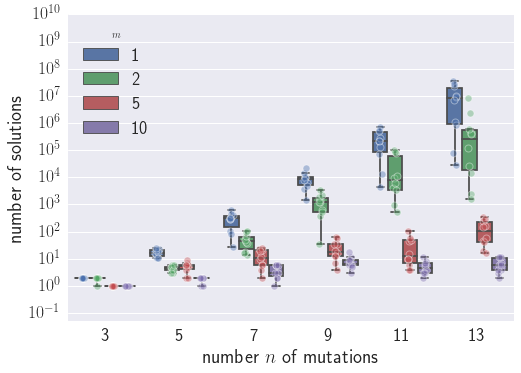

In [39]:
sns.stripplot(data=df, x="n", y="count", hue="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df, x="n", y="count", hue="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper left")
ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("number of solutions")
plt.savefig("solutions.pdf")

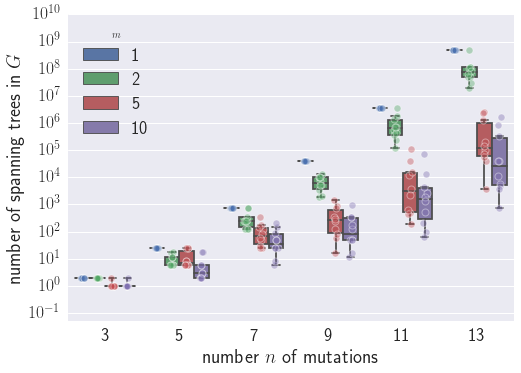

In [40]:
sns.stripplot(data=df, x="n", y="bound", hue="k", split=True, linewidth=1, alpha=.4, jitter=.1)
ax = sns.boxplot(data=df, x="n", y="bound", hue="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper left")
ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("number of spanning trees in $G$")
plt.savefig("spanning_trees.pdf")

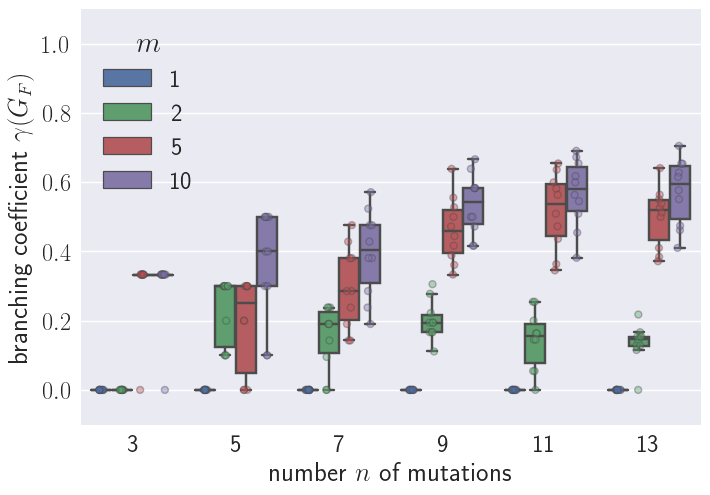

In [13]:
df['gamma']=1-df['inc']
sns.stripplot(data=df, x="n", y="gamma", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="n", y="gamma", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$", loc="upper left")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("branching coefficient $\gamma(G_F)$")
plt.savefig("frac_comparable.pdf")

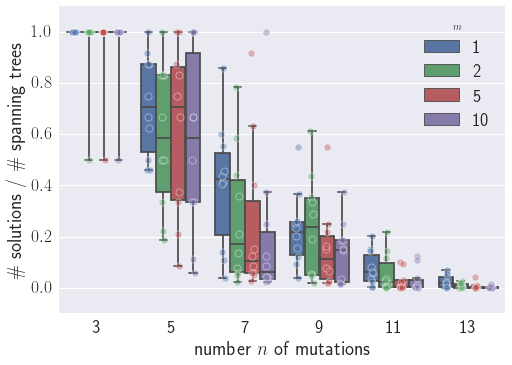

In [42]:
df['ratio'] = df['count'] / df['bound']
sns.stripplot(data=df, x="n", y="ratio", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="n", y="ratio", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("\# solutions / \# spanning trees")
plt.savefig("num_solutions_by_num_spanning_trees.pdf")

In [43]:
df_ext = pd.read_table("results_extended.tsv")
df_ext['ratio'] = df_ext['count'] / df_ext['bound']

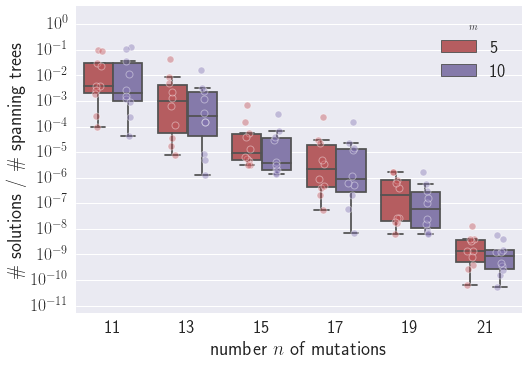

In [44]:
sns.stripplot(data=df_ext, x="n", y="ratio", hue="k", alpha=.4, jitter=.1, linewidth=1, 
              split=True, palette=sns.color_palette()[2:])
ax = sns.boxplot(data=df_ext, x="n", y="ratio", hue="k", showfliers=False,
                 palette=sns.color_palette()[2:])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], title="$m$", loc="upper right")
ax.set(yscale="log")
ax.set_ylim((5e-12, 5))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("\# solutions / \# spanning trees")
plt.savefig("num_solutions_by_num_spanning_trees_ext.pdf")

In [45]:
df_recall = pd.read_table('recall.tsv')

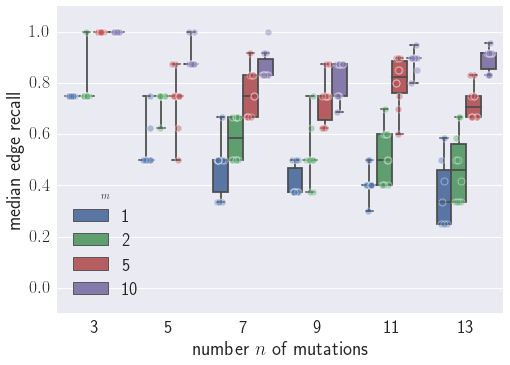

In [46]:
sns.stripplot(data=df_recall, x="n", y="par", hue="k", alpha=.4, jitter=.2, linewidth=1, split=True)
ax = sns.boxplot(data=df_recall, x="n", y="par", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$", loc="lower left")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall.pdf")

In [47]:
df_SCS = pd.read_table("recall_SCS.tsv")

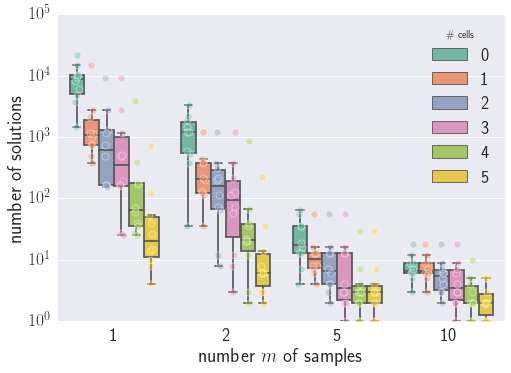

In [48]:
sns.stripplot(data=df_SCS, hue="c", y="count", x="k", alpha=.4, split=True, linewidth=1, 
              jitter=.1, palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df_SCS, hue="c", y="count", x="k", showfliers=False,
                palette=sns.color_palette("Set2", 10))
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# cells", loc="upper right")
# ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("number of solutions")
plt.savefig("solutions_SCS.pdf")

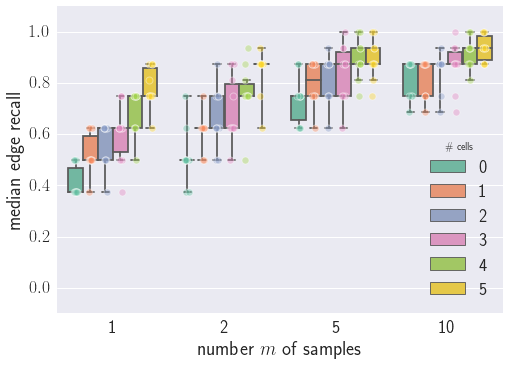

In [49]:
sns.stripplot(data=df_SCS, hue="c", y="par", x="k", alpha=.4, split=True, linewidth=1, 
              jitter=.1, palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df_SCS, hue="c", y="par", x="k", showfliers=False,
                 palette=sns.color_palette("Set2", 10))
# ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# cells", loc="lower right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall_SCS.pdf")

In [50]:
df_LRS = pd.read_table("recall_LRS.tsv")

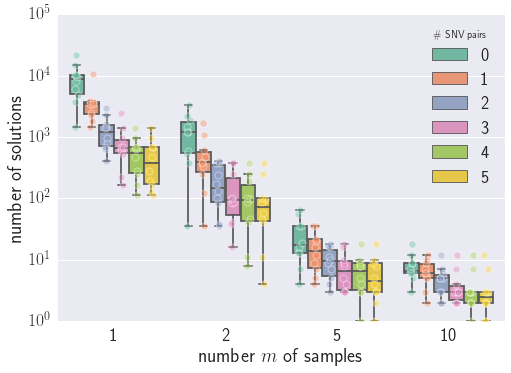

In [51]:
sns.stripplot(data=df_LRS, hue="r", y="count", x="k", alpha=.4, split=True, linewidth=1, 
              jitter=.1, palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df_LRS, hue="r", y="count", x="k", showfliers=False,
                 palette=sns.color_palette("Set2", 10))
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# SNV pairs", loc="upper right")
# ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("number of solutions")
plt.savefig("solutions_LRS.pdf")

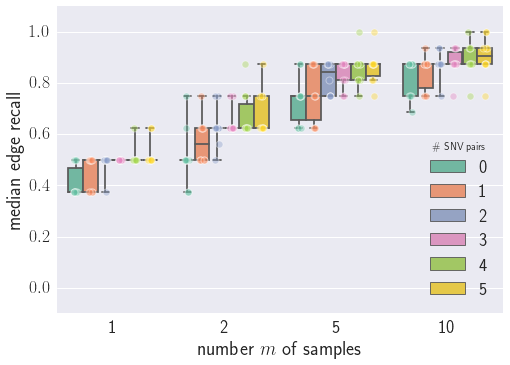

In [52]:
sns.stripplot(data=df_LRS, hue="r", y="par", x="k", alpha=.4, split=True, linewidth=1, 
              jitter=.1, palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df_LRS, hue="r", y="par", x="k", showfliers=False,
                 palette=sns.color_palette("Set2", 10))
# ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# SNV pairs", loc="lower right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall_LRS.pdf")

In [7]:
def identifySolution(filename):
    filename = os.path.basename(filename).rstrip(".tsv\n")
    instance = '_'.join(filename.split('_')[0:2])
    return oncolib.identifySolution("enumerate_output/" + filename + "_clustered_trees.txt", 
                                    "simulate_output/" + instance + ".tree")

In [59]:
def uniformityTest(filename):
    df = pd.read_table(filename)
    df = df[df['index'] >= 0]
    nrSols = df['count'].sum()
#     if nrSols == 0:
#         return 1
#     else:
    return chisquare(df['count'])[1]

In [60]:
uniformityTest('rejection_out/n7_S12_k1.tsv')

0.72325649377835255

In [36]:
identifySolution('PhyloWGS_output/n7_S12_k5.tsv')

0

In [9]:
def plot_uniformity(filename, ax):
    df = pd.read_table(filename)
    df = df.sort_values('index')
    nrTrueSols = df['index'].max()+1
    nrSols = df['count'].sum()
    nrIncorrectSols = len(df[df['index'] < 0])
    nrCorrectSols = len(df[(df['index'] >= 0) & (df['count'] > 0)])
    df['rel_count'] = df['count'] / nrSols
    u = (nrSols / float(nrTrueSols)) / nrSols
    df_correct = df[df['index'] >= 0].sort_values('count', ascending = False)
    df_incorrect = df[df['index'] < 0].sort_values('count')
    df = pd.concat([df_incorrect, df_correct])
    df.reset_index(inplace=True)
    df.plot(x='index', y='rel_count', kind='bar', width=.75, ax=ax, legend=False, 
            color=['red' if x < 0 else 'blue' for x in df['index']])
    ax.plot((nrIncorrectSols - .5, nrIncorrectSols+nrTrueSols),(u,u), ls='dashed')
    solIdx = identifySolution(filename)
    assert solIdx != -1
#         print df
#         print df[df['index'] == identifySolution(filename)].index[0]
#         print [df[df['index'] == identifySolution(filename)].index[0]]
#         print identifySolution(filename)
    ax.plot([df[df['index'] == solIdx].index[0]], 
            [u], marker='*', markersize=20)
#     ax.text(.85, .9, '$p = %.2f$' % uniformityTest(filename),
#             horizontalalignment='center',
#             verticalalignment='center',
#             transform = ax.transAxes)
    ax.set_xticklabels([])
#     ax.set_ylim((-.05,1))
    ax.set_title("$%d/%d/%d$ $(p = %.2f)$" % 
                 (nrIncorrectSols, nrCorrectSols, nrTrueSols, uniformityTest(filename)))
    ax.set_xlabel("")

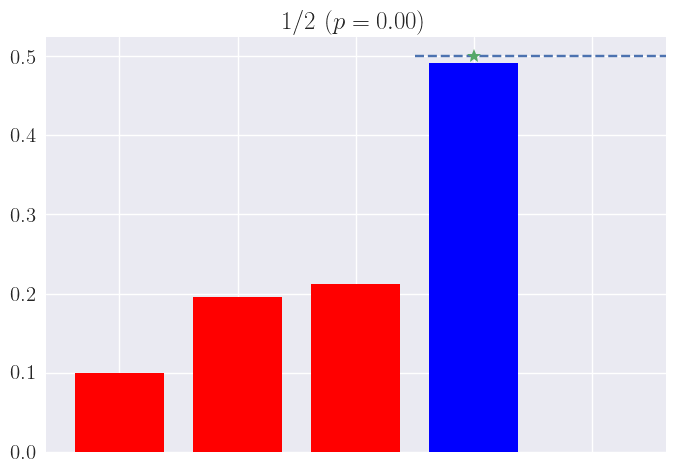

In [78]:
plot_uniformity('r_output/old/n7_S81_k10.tsv', plt.gca())

In [10]:
def plotAll(directory, filename):
    nrRows=10
    nrCols=4
    idx = 0
    for S in [7,10,12,23,30,43,49,61,66,81]:
        for k in [1,2,5,10]:
            idx += 1
            ax = plt.subplot(nrRows, nrCols, idx)
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
            if os.path.exists('%s/n7_S%d_k%d.tsv' % (directory, S, k)):
                plot_uniformity('%s/n7_S%d_k%d.tsv' % (directory, S, k), ax)
            else:
                ax.text(.45, .5, "\Huge n/a")
                ax.set_xticklabels([])
                if k != 1:
                    ax.set_yticklabels([])
            if S == 81:
                ax.set_xlabel("$m=%d$" % k)
            if k == 1:
                ax.set_ylabel("\# %d" % S)
    plt.gcf().set_size_inches(15, 20)
    plt.tight_layout()
    plt.savefig(filename)

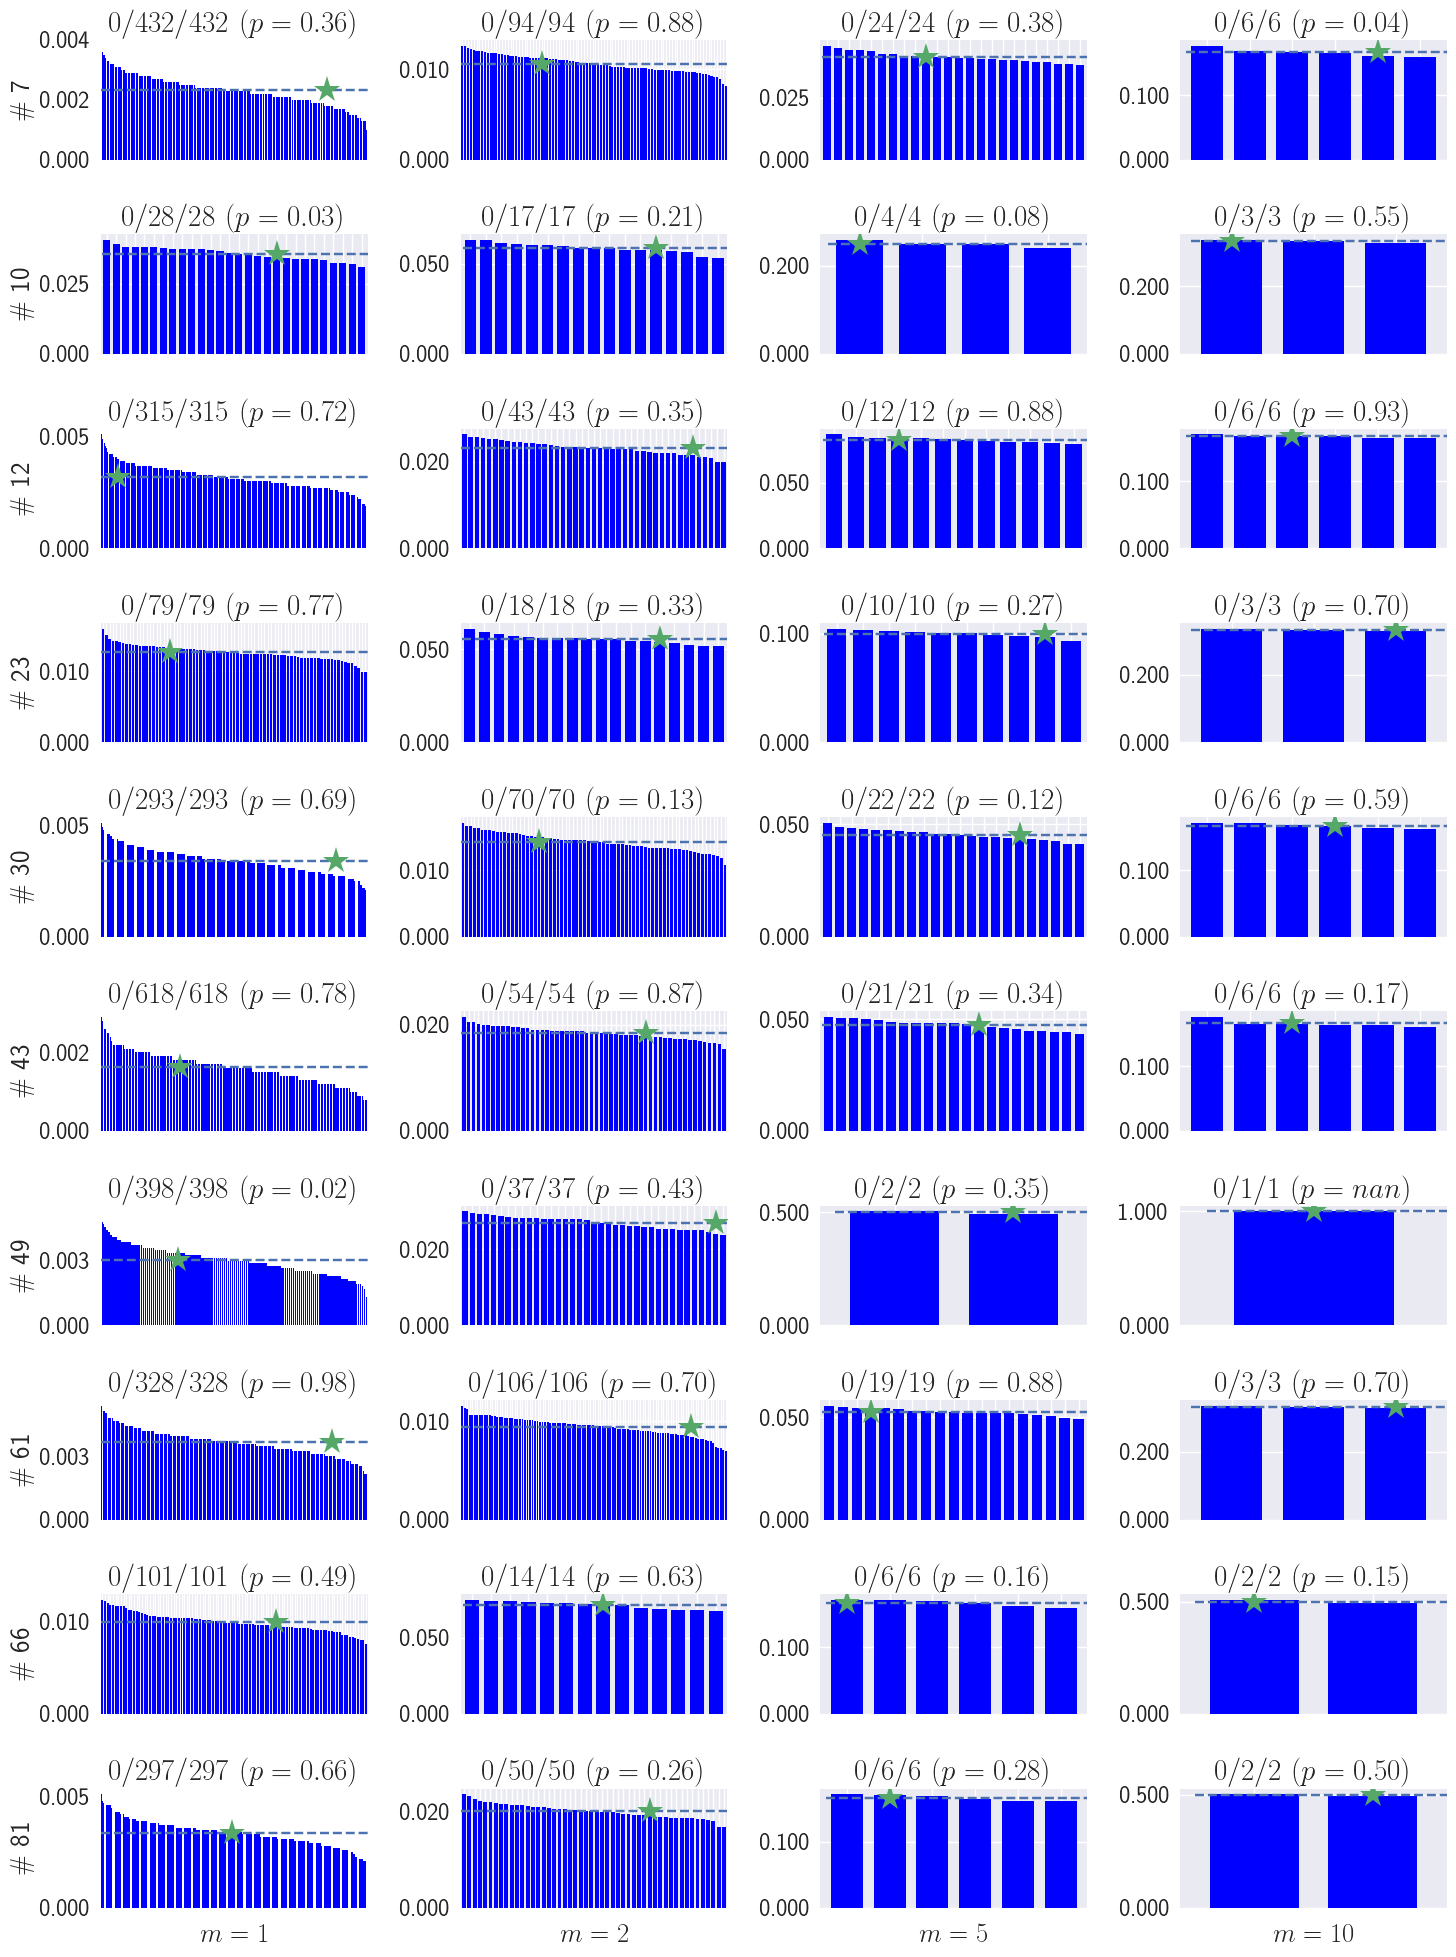

In [11]:
plotAll("rejection_out", "rejection.pdf")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:4376: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


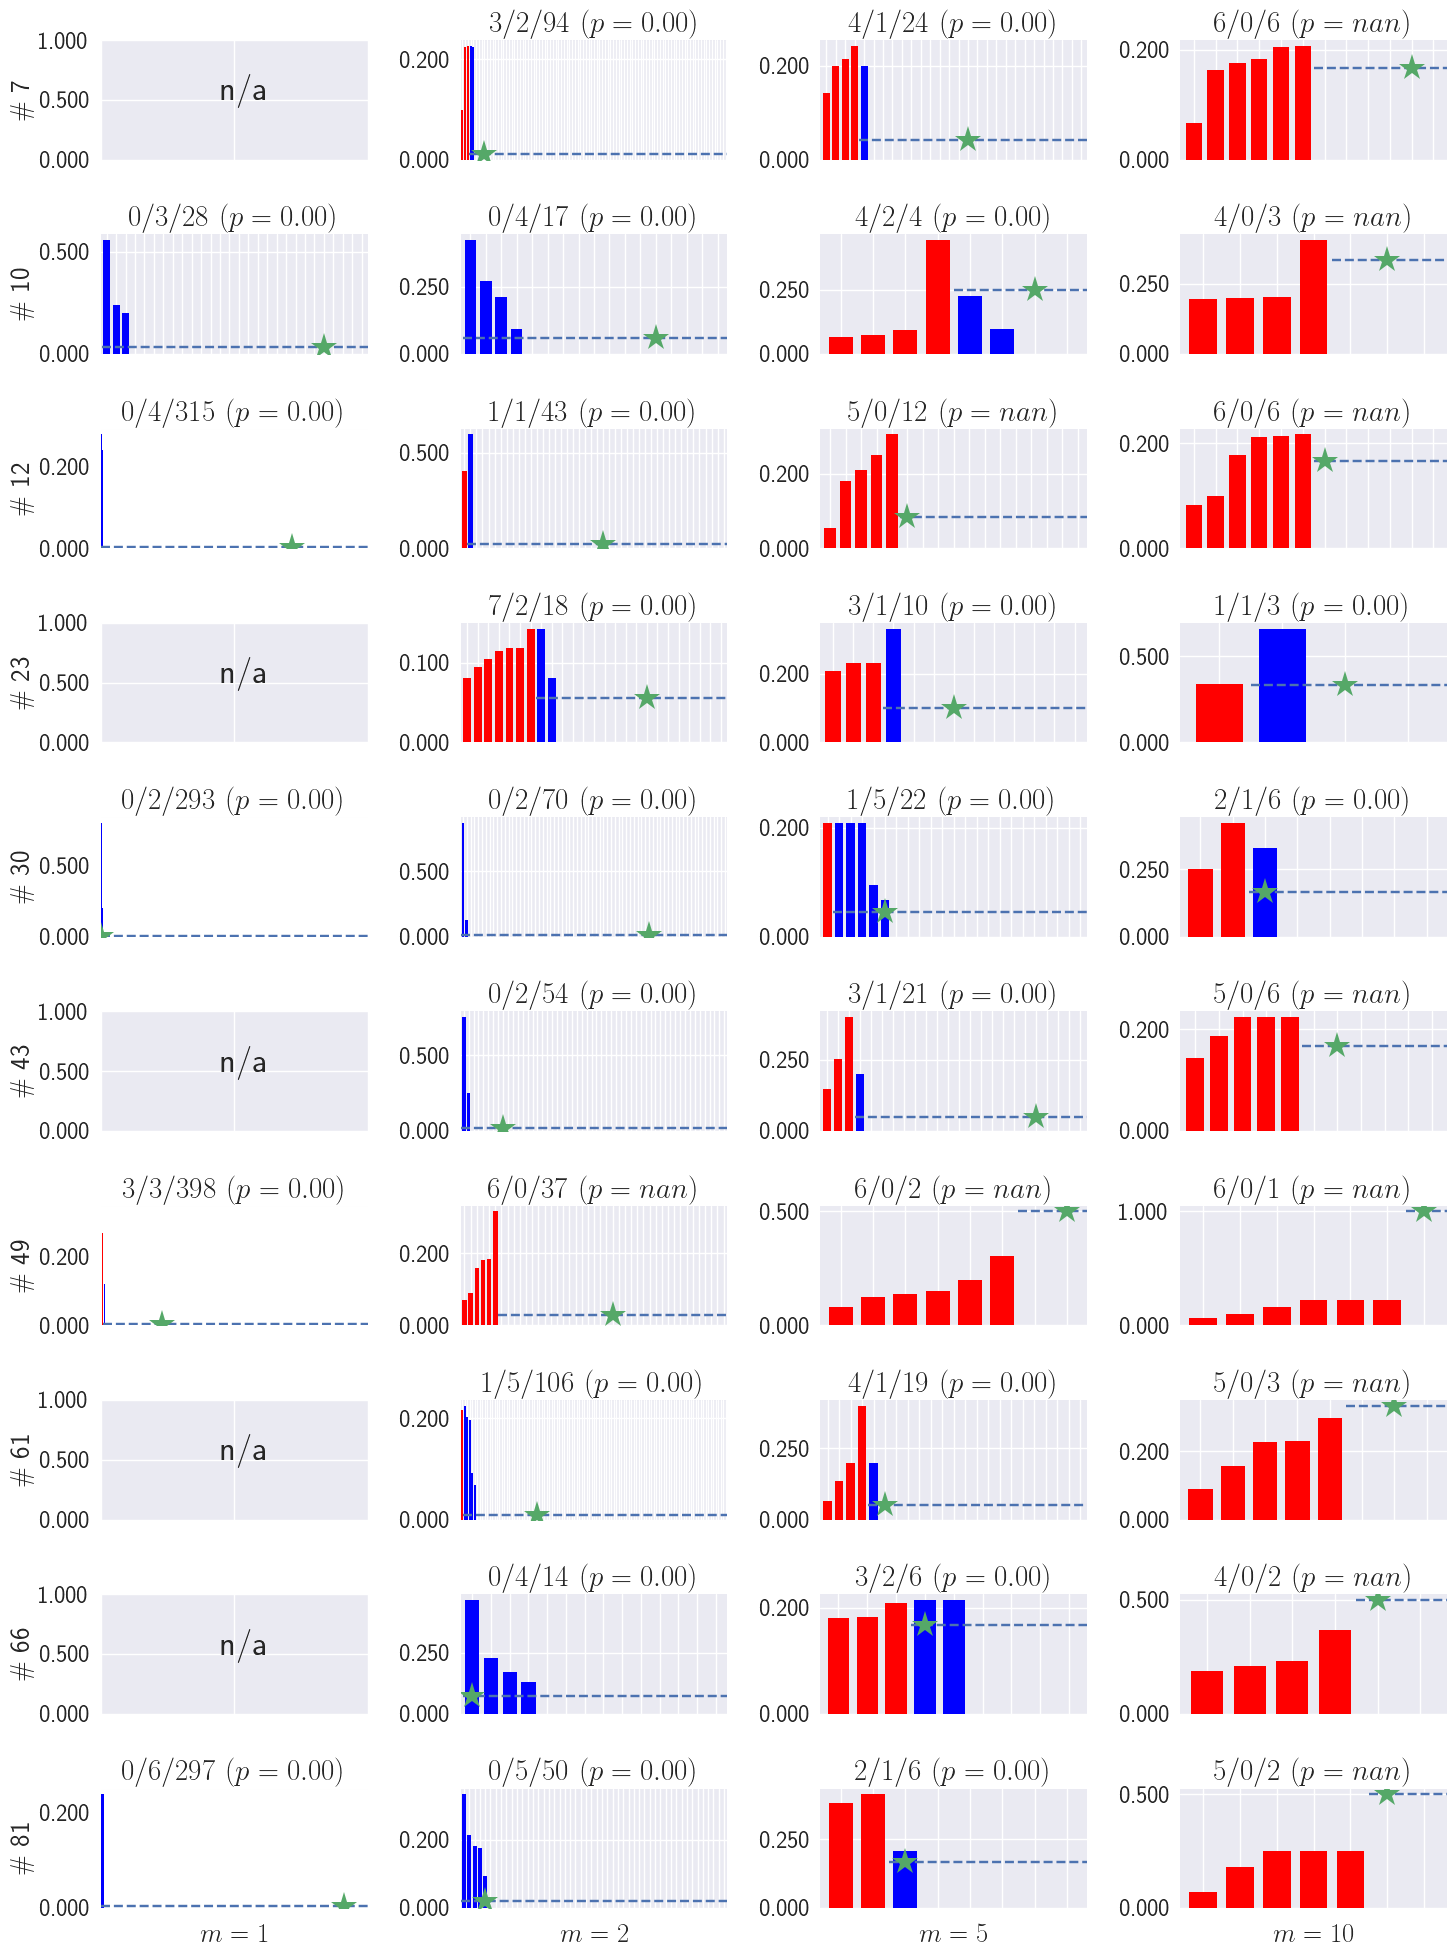

In [28]:
plotAll("r_output", "canopy.pdf")

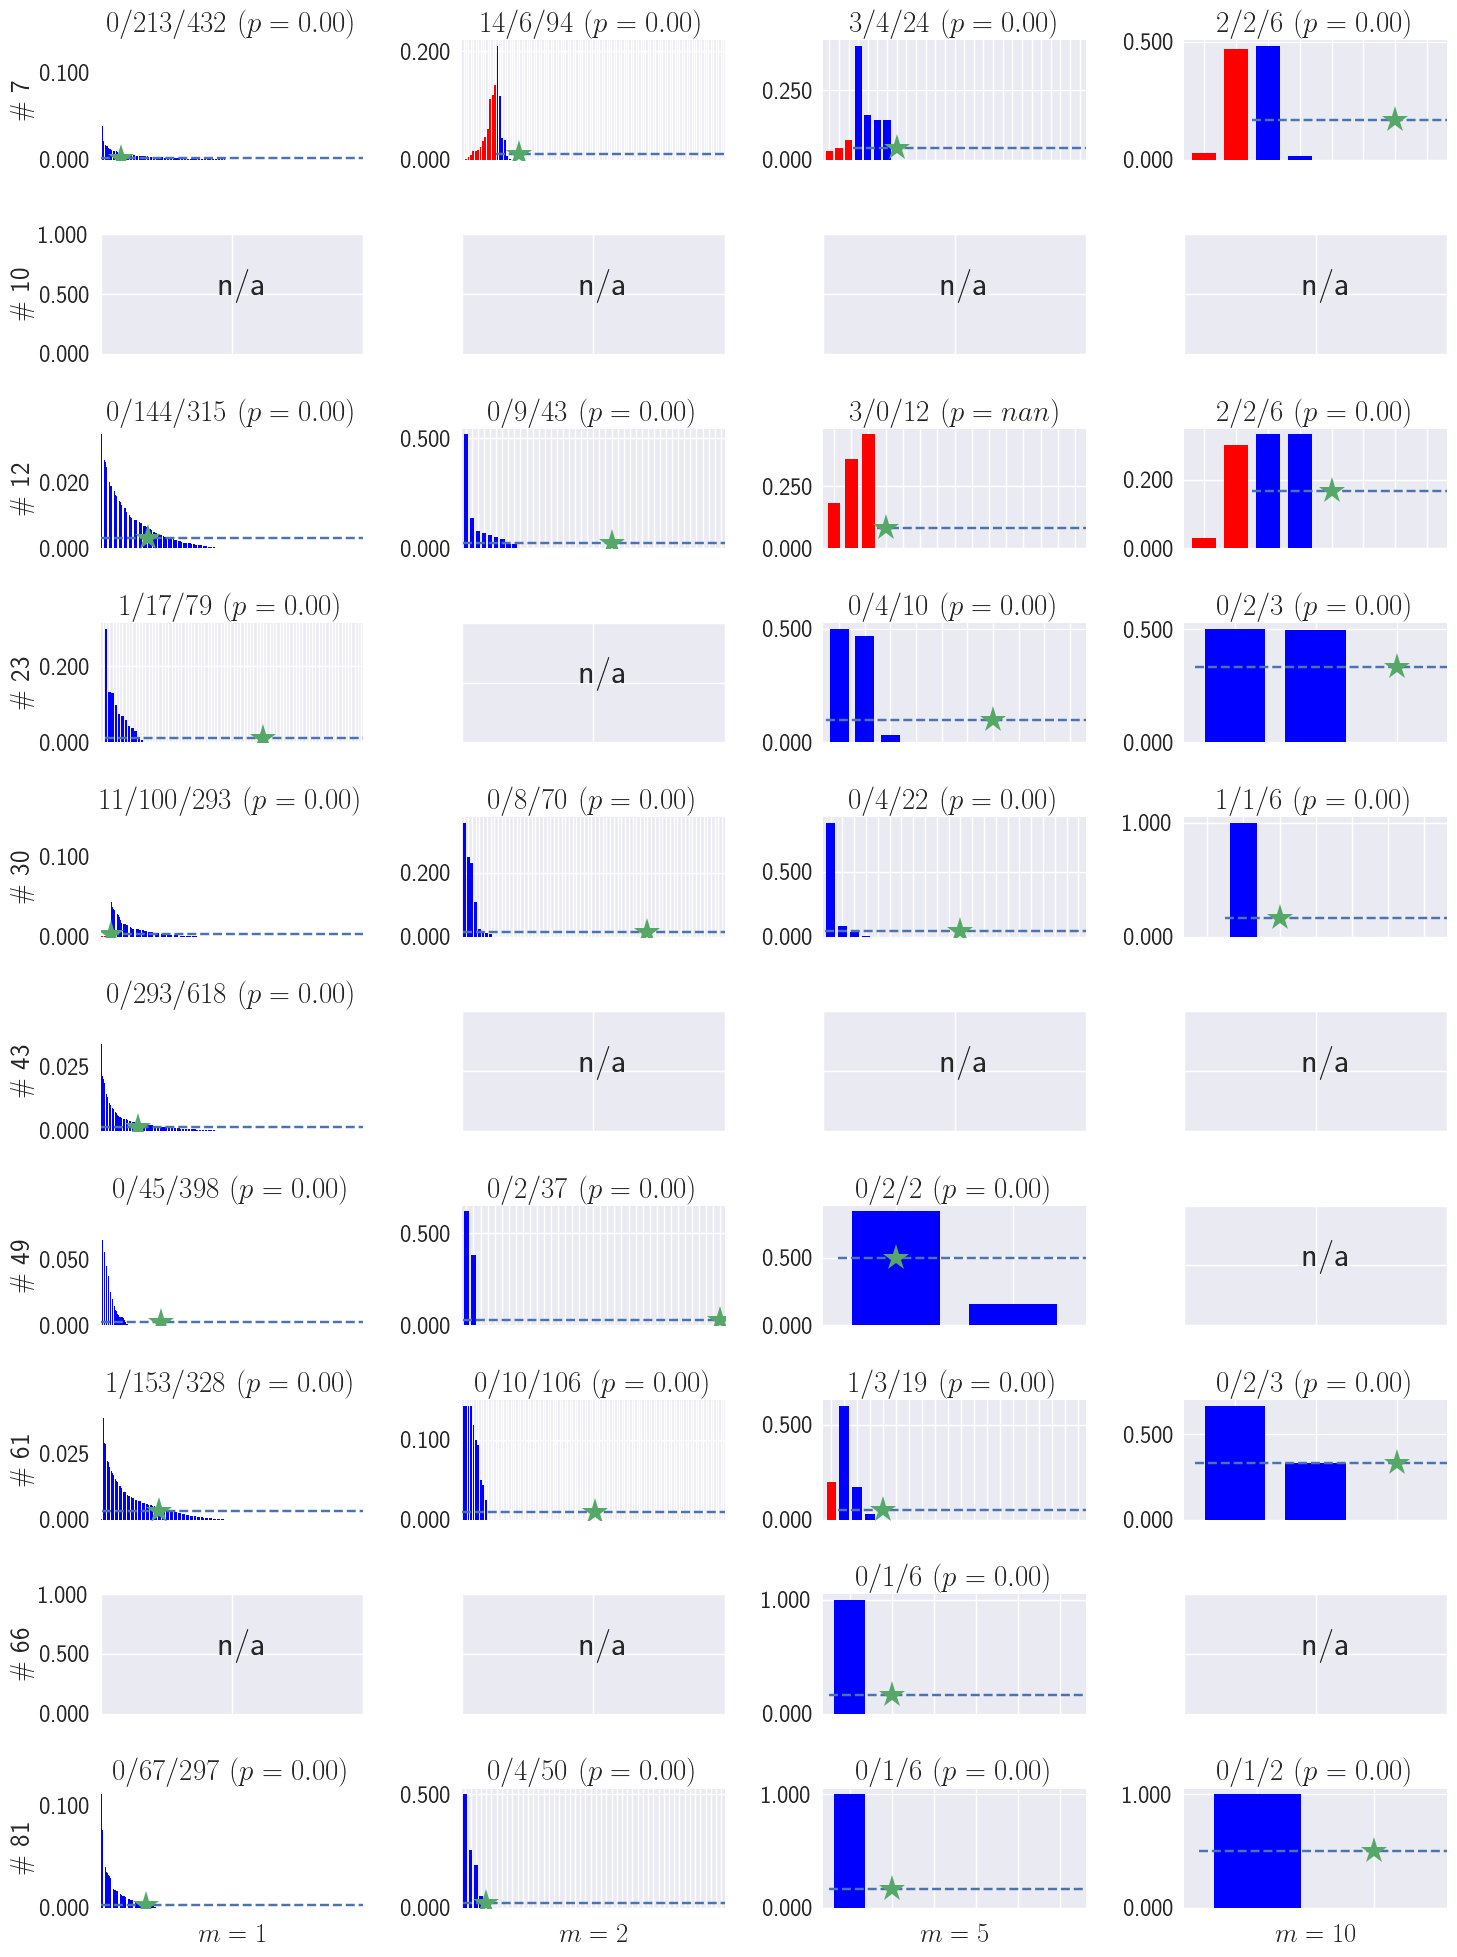

In [153]:
plotAll("PhyloWGS_output", "PhyloWGS.pdf")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:4376: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


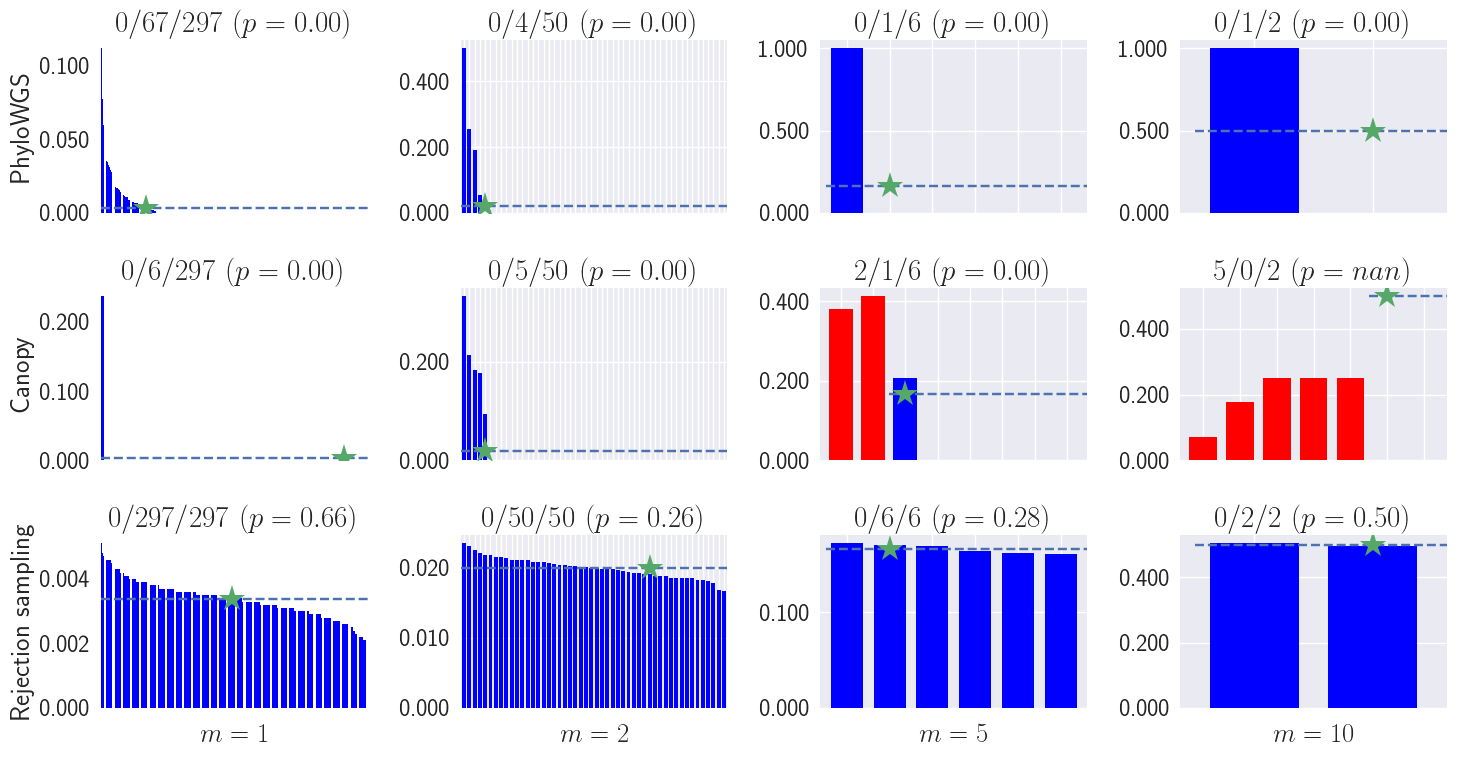

In [12]:
nrRows=3
nrCols=4
S=81
ax = plt.subplot(nrRows, nrCols, 1)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
ax.set_ylabel("PhyloWGS")
plot_uniformity('PhyloWGS_output/n7_S%d_k1.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 2)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('PhyloWGS_output/n7_S%d_k2.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 3)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('PhyloWGS_output/n7_S%d_k5.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 4)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('PhyloWGS_output/n7_S%d_k10.tsv' % S, ax)

ax = plt.subplot(nrRows, nrCols, 5)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
ax.set_ylabel("Canopy")
plot_uniformity('r_output/n7_S%d_k1.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 6)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('r_output/n7_S%d_k2.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 7)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('r_output/n7_S%d_k5.tsv' % S, ax)
ax = plt.subplot(nrRows, nrCols, 8)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('r_output/n7_S%d_k10.tsv' % S, ax)

ax = plt.subplot(nrRows, nrCols, 9)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
ax.set_ylabel("Rejection sampling")
plot_uniformity('rejection_out/n7_S%d_k1.tsv' % S, ax)
ax.set_xlabel("$m=1$")
ax = plt.subplot(nrRows, nrCols, 10)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('rejection_out/n7_S%d_k2.tsv' % S, ax)
ax.set_xlabel("$m=2$")
ax = plt.subplot(nrRows, nrCols, 11)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('rejection_out/n7_S%d_k5.tsv' % S, ax)
ax.set_xlabel("$m=5$")
ax = plt.subplot(nrRows, nrCols, 12)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plot_uniformity('rejection_out/n7_S%d_k10.tsv' % S, ax)
ax.set_xlabel("$m=10$")
plt.gcf().set_size_inches(15, 8)
plt.tight_layout()
plt.savefig("uniformity.pdf")

## Generate Graphviz visualizations of m=5, n=7 and S=8 trees

In [10]:
for idx in range(6):
    g=gv.Source(oncolib.enumeratedtree2dot("mix_output/n7_S81_k5_clustered.tsv", 
                                           "enumerate_output/n7_S81_k5_clustered_trees.txt", idx))
    g.render("n7_S81_k5_T%d.pdf" % idx)

# 3. Tables

In [13]:
df_rej = pd.read_table("rejection_out/rejection.tsv")

In [83]:
print "\\begin{tabular}{|c|c|c|c|c||c|c|}"
print "\\hline"
print " & ".join(["\#", "samples $m$", "solutions", "spanning trees", 
                  "ratio", "trials", "success ratio"]) + "\\\\"
print "\\hline"
for S in sorted(df_rej.S.unique()):
    for k in [1,2,5,10]:
        if k == 1:
            print "\\hline"
            print "\multirow{4}{*}{$%d$}" % S,
        trials = df_rej[(df_rej['S'] == S) & (df_rej['k'] == k)].trials
        solutions = df[(df['n'] == 7) & (df['seed'] == S) & (df['k'] == k)]['count']
        bound = int(df[(df['n'] == 7) & (df['seed'] == S) & (df['k'] == k)].bound)
        print "& $%d$ & %d & %d & %.3f & %d & %.3f\\\\" % (k, solutions, bound, 
                                                       float(solutions) / bound, 
                                                       trials, 10000. / trials)
print "\\hline"
print "\\end{tabular}"

\begin{tabular}{|c|c|c|c|c||c|c|}
\hline
\# & samples $m$ & solutions & spanning trees & ratio & trials & success ratio\\
\hline
\hline
\multirow{4}{*}{$7$} 720
& $1$ & 432 & 720 & 0.600 & 16585 & 0.603\\
120
& $2$ & 94 & 120 & 0.783 & 12753 & 0.784\\
60
& $5$ & 24 & 60 & 0.400 & 24821 & 0.403\\
24
& $10$ & 6 & 24 & 0.250 & 40859 & 0.245\\
\hline
\multirow{4}{*}{$10$} 720
& $1$ & 28 & 720 & 0.039 & 256090 & 0.039\\
720
& $2$ & 17 & 720 & 0.024 & 419637 & 0.024\\
144
& $5$ & 4 & 144 & 0.028 & 358360 & 0.028\\
144
& $10$ & 3 & 144 & 0.021 & 481517 & 0.021\\
\hline
\multirow{4}{*}{$12$} 720
& $1$ & 315 & 720 & 0.438 & 23109 & 0.433\\
120
& $2$ & 43 & 120 & 0.358 & 28009 & 0.357\\
80
& $5$ & 12 & 80 & 0.150 & 67803 & 0.147\\
48
& $10$ & 6 & 48 & 0.125 & 78530 & 0.127\\
\hline
\multirow{4}{*}{$23$} 720
& $1$ & 79 & 720 & 0.110 & 90828 & 0.110\\
360
& $2$ & 18 & 360 & 0.050 & 197369 & 0.051\\
180
& $5$ & 10 & 180 & 0.056 & 180518 & 0.055\\
90
& $10$ & 3 & 90 & 0.033 & 300223 & 0.033\\
\hline

In [116]:
for N in [3,5,7]:
    print "\\begin{table}" 
    print "\\caption{$n$ = " + str(N) + "}"
    print "\\center"

    print "\\begin{tabular}{|c|c|c|c|c|}"
    print "\\hline"
    print " & ".join(["\#", "samples $m$", "solutions", "spanning trees", 
                      "ratio"]) + "\\\\"
    print "\\hline"
    for S in sorted(df[(df['n'] == N)]['seed'].unique()):
        for k in [1,2,5,10]:
            if k == 1:
                print "\\hline"
                print "\multirow{4}{*}{$%d$}" % S,
            solutions = df[(df['n'] == N) & (df['seed'] == S) & (df['k'] == k)]['count']
            bound = df[(df['n'] == N) & (df['seed'] == S) & (df['k'] == k)]['bound']
            bound = int(bound)
            print "& $%d$ & %d & %d & %.3f\\\\" % (k, solutions, bound, 
                                                       float(solutions) / bound)
    print "\\hline"
    print "\\end{tabular}"
    print "\\end{table}"
    

\begin{table}
\caption{$n$ = 9}
\center
\begin{tabular}{|c|c|c|c|c|}
\hline
\# & samples $m$ & solutions & spanning trees & ratio\\
\hline
\hline
\multirow{4}{*}{$0$} & $1$ & 1472 & 40320 & 0.037\\
& $2$ & 36 & 1920 & 0.019\\
& $5$ & 7 & 360 & 0.019\\
& $10$ & 5 & 360 & 0.014\\
\hline
\multirow{4}{*}{$5$} & $1$ & 10445 & 40320 & 0.259\\
& $2$ & 2200 & 5040 & 0.437\\
& $5$ & 4 & 16 & 0.250\\
& $10$ & 3 & 12 & 0.250\\
\hline
\multirow{4}{*}{$18$} & $1$ & 6180 & 40320 & 0.153\\
& $2$ & 1450 & 5040 & 0.288\\
& $5$ & 13 & 60 & 0.217\\
& $10$ & 9 & 48 & 0.188\\
\hline
\multirow{4}{*}{$24$} & $1$ & 4776 & 40320 & 0.118\\
& $2$ & 522 & 10080 & 0.052\\
& $5$ & 36 & 1440 & 0.025\\
& $10$ & 12 & 960 & 0.013\\
\hline
\multirow{4}{*}{$27$} & $1$ & 3755 & 40320 & 0.093\\
& $2$ & 382 & 7560 & 0.051\\
& $5$ & 16 & 864 & 0.019\\
& $10$ & 6 & 360 & 0.017\\
\hline
\multirow{4}{*}{$31$} & $1$ & 8183 & 40320 & 0.203\\
& $2$ & 600 & 13440 & 0.045\\
& $5$ & 19 & 288 & 0.066\\
& $10$ & 6 & 180 & 0.033\\
\hlin

In [20]:
for N in [9,11,13]:
    print "\\begin{table}" 
    print "\\caption{$n$ = " + str(N) + "}"
    print "\\center"

    print "\\begin{tabular}{|c|c|c|c|c|}"
    print "\\hline"
    print " & ".join(["\#", "samples $m$", "solutions", "spanning trees", 
                      "ratio"]) + "\\\\"
    print "\\hline"
    for S in sorted(df[(df['n'] == N)]['seed'].unique()):
        for k in [1,2,5,10]:
            if k == 1:
                print "\\hline"
                print "\multirow{4}{*}{$%d$}" % S,
            solutions = df[(df['n'] == N) & (df['seed'] == S) & (df['k'] == k)]['count']
            bound = df[(df['n'] == N) & (df['seed'] == S) & (df['k'] == k)]['bound']
            bound = int(bound)
            print "& $%d$ & %d & %d & %.3f\\\\" % (k, solutions, bound, 
                                                       float(solutions) / bound)
    print "\\hline"
    print "\\end{tabular}"
    print "\\end{table}"
    

\begin{table}
\caption{$n$ = 9}
\center
\begin{tabular}{|c|c|c|c|c|}
\hline
\# & samples $m$ & solutions & spanning trees & ratio\\
\hline
\hline
\multirow{4}{*}{$0$} & $1$ & 1472 & 40320 & 0.037\\
& $2$ & 36 & 1920 & 0.019\\
& $5$ & 7 & 360 & 0.019\\
& $10$ & 5 & 360 & 0.014\\
\hline
\multirow{4}{*}{$5$} & $1$ & 10445 & 40320 & 0.259\\
& $2$ & 2200 & 5040 & 0.437\\
& $5$ & 4 & 16 & 0.250\\
& $10$ & 3 & 12 & 0.250\\
\hline
\multirow{4}{*}{$18$} & $1$ & 6180 & 40320 & 0.153\\
& $2$ & 1450 & 5040 & 0.288\\
& $5$ & 13 & 60 & 0.217\\
& $10$ & 9 & 48 & 0.188\\
\hline
\multirow{4}{*}{$24$} & $1$ & 4776 & 40320 & 0.118\\
& $2$ & 522 & 10080 & 0.052\\
& $5$ & 36 & 1440 & 0.025\\
& $10$ & 12 & 960 & 0.013\\
\hline
\multirow{4}{*}{$27$} & $1$ & 3755 & 40320 & 0.093\\
& $2$ & 382 & 7560 & 0.051\\
& $5$ & 16 & 864 & 0.019\\
& $10$ & 6 & 360 & 0.017\\
\hline
\multirow{4}{*}{$31$} & $1$ & 8183 & 40320 & 0.203\\
& $2$ & 600 & 13440 & 0.045\\
& $5$ & 19 & 288 & 0.066\\
& $10$ & 6 & 180 & 0.033\\
\hlin